In [1]:
import numpy as np
from scipy.special import erf, erfinv
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 3, 3
N_HVC = N_syl * N_HVC_per_syl

In [3]:
PEAK_RATE, KERNEL_WIDTH = 150, 20

In [4]:
T_rend = 600 # Each rendition
N_rend = 25 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

(3, 600)


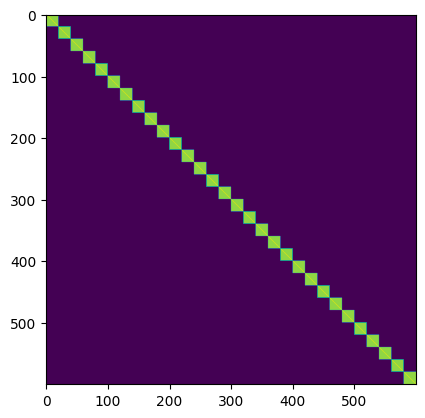

In [5]:
# Syllables and time stamps
# syl = rng.normal(1, 3, size=(N_syl, NE))#.clip(min=0)
N_shared_channels = 20
syl_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
plt.imshow(syl_cov)
syl = rng.multivariate_normal(np.ones(NE), syl_cov, size=N_syl)
print(syl.shape)

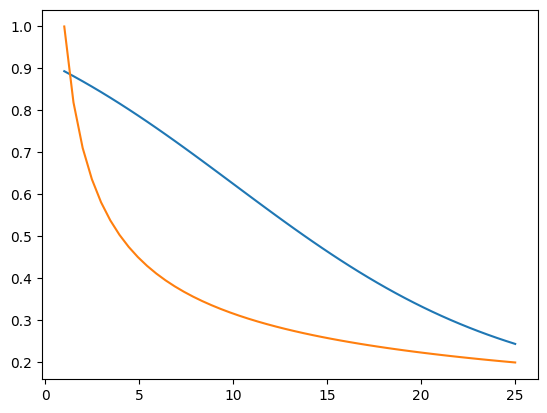

In [6]:
_ = np.linspace(1, N_rend)
plt.plot(_, (np.tanh(-(_-10)/15)+1.25)/2)
plt.plot(_, np.power(_, -0.5))

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'HVC rates (Hz)')]

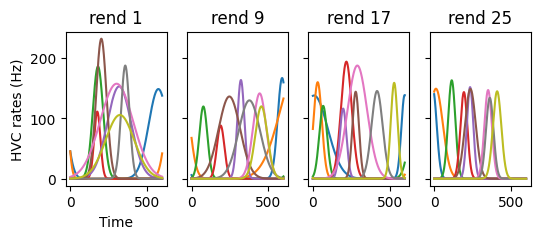

In [7]:
tsyl_start, tsyl_end, burst_ts = generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)
save_W_ts = np.round(tsyl_end[-1]).astype(int)
peak_rate = np.zeros_like(burst_ts)
kernel_width = np.zeros_like(burst_ts) + KERNEL_WIDTH
for i in range(N_rend):
    j = (np.tanh(-(i-10)/15)+1.25)/2
    burst_ts[:,i] += rng.normal(loc=0, scale=80*j, size=9)
    peak_rate[:,i] = lognormal_gen(rng, PEAK_RATE, 50*j, size=9)
    kernel_width[:,i] += rng.exponential(40*j, size=9)
rH = generate_HVC(T, burst_ts, peak_rate, kernel_width)

js = (0, int(np.floor(N_rend/3)), int(np.floor(N_rend*2/3)), N_rend-1)
fig, ax = plt.subplots(1, len(js), figsize=(6, 2), sharex='all', sharey='all')
for i, j in enumerate(js):
    ax[i].plot(rH[T_burn+j*T_rend:T_burn+(j+1)*T_rend])
    ax[i].set_title(f'rend {j+1}', fontsize=12)
ax[0].set(xlabel='Time', ylabel='HVC rates (Hz)')

In [8]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

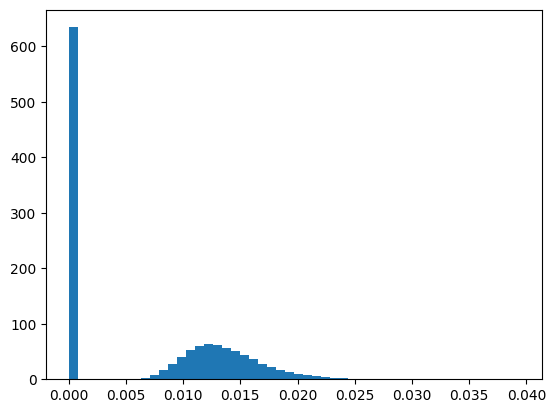

In [9]:
gen = lognormal_gen
# gen = const_gen
c = 0.5
JEE0, JEI0, JIE0, JII0 = np.array([1, 0.8, 1.2, 0.6]) / 3
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.25
# c = 1
# JEE0, JEI0, JIE0, JII0 = np.array([1, 0.8, 1.25, 0.9])
# sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.25
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=c<=0.5) / np.sqrt(NE)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=c<=0.5) / np.sqrt(NI)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=c<=0.5) / np.sqrt(NE)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=c<=0.5) / np.sqrt(NI)
# plt.hist(JEE.flatten(), bins=50, density=True);
plt.hist(JEE.toarray().flatten(), bins=50, density=True);

In [10]:
rEmax, rImax, thE, thI, sE, sI = 40, 100, -5, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

In [11]:
w0_mean = 1/N_HVC
w_inh, wI = w0_mean, 0.0
tauE, tauI, dt = 40, 10, 1

net = EINet(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, 
            JEE=JEE, JEI=JEI, JIE=JIE, JII=JII, w_inh=w_inh, wI=wI, w0_std=1e-3)

100%|███████████████████████████████████████| 999/999 [00:00<00:00, 3614.74it/s]


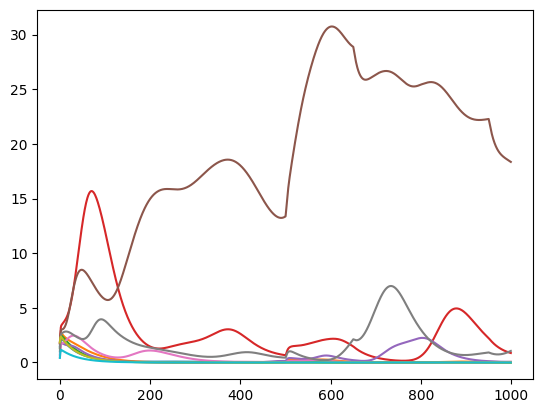

In [12]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
aux = [np.zeros_like(rH[:1000])+rH[:1000].mean(axis=1)[:,None], 
       np.zeros_like(aud[:1000])+aud[:1000].mean(axis=1)[:,None]]
_ = net.sim(rE0, rI0, *aux, [], 1000, dt, 0)
rE, rI, Ws, mean_HVC_input, hE = _
plt.plot(rE[:1000,:10]);

In [13]:
def bilin_hebb(net, aiv, hvc, lr, w0_mean, tauW):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * (aiv - 1) * h - (net.W[:,i] - w0_mean)
        net.W[:,i] = np.clip(net.W[:,i] + dW / tauW, a_min=0, a_max=None)

In [14]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
_ = net.sim(rE0, rI0, rH, aud, save_W_ts, T, dt, 1, bilin_hebb,
            lr=-8e-2, w0_mean=w0_mean, tauW=1e5)
rE, rI, Ws, mean_HVC_input, hE = _

100%|███████████████████████████████████| 15499/15499 [00:11<00:00, 1398.59it/s]


(<Figure size 400x600 with 4 Axes>,
 array([<Axes: ylabel='$\\left\\langle \\| W \\|_F \\right\\rangle$'>,
        <Axes: ylabel='mean input\nfrom HVC'>,
        <Axes: ylabel='Mean exc. rate'>,
        <Axes: xlabel='Time (a.u.)', ylabel='Mean inh. rate'>],
       dtype=object))

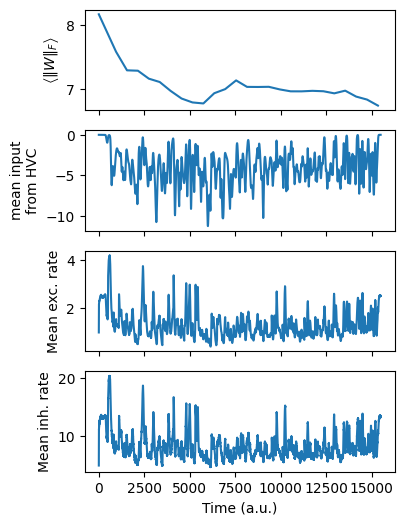

In [15]:
plot_train_stats(Ws, rE, mean_HVC_input, save_W_ts, rI)

In [16]:
W_syl_corrs = [correlation(_.T, syl, dim=2) for _ in Ws]

(<Figure size 700x200 with 5 Axes>,
 array([<Axes: title={'center': 'Rendition 0'}, ylabel='HVC index'>,
        <Axes: title={'center': 'Rendition 8'}>,
        <Axes: title={'center': 'Rendition 17'}>,
        <Axes: title={'center': 'Rendition 25'}>], dtype=object))

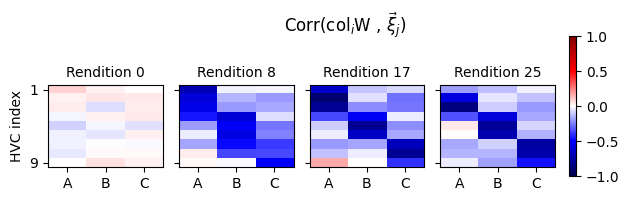

In [17]:
plot_wcol_corr(W_syl_corrs, (1, 4), (7, 2))

530


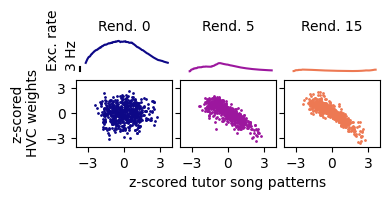

In [18]:
i = 0
rends = (0, 5, 15)
_ = [rE[int(tsyl_start[i,j]):int(tsyl_end[i,j])].mean(axis=0) for j in rends]
k = rng.choice(np.where((_[0]>_[1]+0.5)&(_[1]>_[2]+0.5))[0])
print(k)
fig, ax = plt.subplots(2, 3, figsize=(4, 2), sharey='row', sharex='row', 
                       height_ratios=[1, 2])
cmap = plt.get_cmap('plasma')
for c, j in enumerate(rends):
    ax[0,c].plot(rE[int(tsyl_start[i,j]):int(tsyl_end[i,j]),k], color=cmap(c/3))
    ax[0,c].set_title('Rend. %d' % j, fontsize=10)
    ax[1,c].plot(normalize(syl[i], 0), normalize(Ws[j][:,i*3+1], 0), '.', 
                 ms=2, color=cmap(c/3))
    ax[1,c].set(xlim=[-4, 4], ylim=[-4, 4], xticks=[-3, 0, 3])
    ax[0,c].set_axis_off()
ax[0,0].plot([-10, -10], [0, 3], c='k')
ax[0,0].text(-25, 0, '3 Hz', va='bottom', ha='center', rotation=90)
ax[0,0].text(-60, 0, 'Exc. rate', va='bottom', ha='center', rotation=90)
# ax[0,0].legend(loc=(0, 1), title='Rendition #', ncols=3, frameon=False, 
#            handlelength=1, columnspacing=1)
ax[1,0].set(yticks=[-3, 0, 3], ylabel='z-scored\n'r'HVC weights')
ax[1,1].set_xlabel('z-scored tutor song patterns')
fig.tight_layout(w_pad=0.2, h_pad=0.5)
# fig.savefig('svg/training_res.svg')
# 2x3; label HVC inputs vs auditory inputs

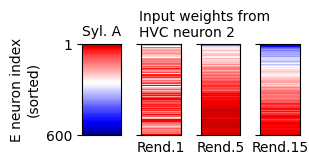

In [19]:
fig, ax = plot_example_colW_syl(Ws, syl[0], 1, [1, 5, 15])
# fig.savefig('weights.svg')

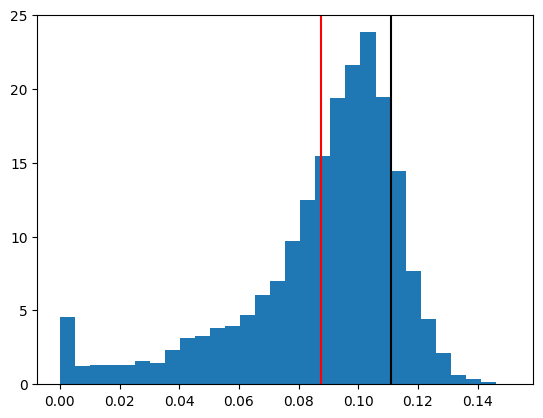

In [20]:
plt.hist(Ws[-1].flatten(), density=True, bins=30)
plt.axvline(Ws[-1].mean(), color='r')
plt.axvline(w0_mean, color='k')

## Test Model with Different Scenarios

In [21]:
Experiment.AUD_LIST

('correct', 'shuf_syl_idx', 'perturb', 'off')

In [22]:
rH_exp = generate_HVC(T_burn+T_rend, generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)[-1], 
                      np.zeros_like(burst_ts)+PEAK_RATE, np.zeros_like(burst_ts)+KERNEL_WIDTH)

In [23]:
exp = Experiment(net, rH_exp, syl, noise=1, T_test=T_burn+T_rend, 
                 t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
pert_mean = np.ones(NE)
pert_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
pert_args = [(pert_mean, pert_cov, 0)]
test_codes = ('correct', 'perturb', 'off', 'correct') # last one for playback
if_sing = (True, True, True, False)
test_names = ('Singing\ncorrect', 'Singing\nperturb',
              'Singing\ndeafen', 'Playback\n')
tests_all = exp.sim_multi(test_codes, if_sing, pert_args * len(test_codes))

100%|██████████████████████████████████████| 1099/1099 [00:01<00:00, 907.81it/s]


In [24]:
rE_block_avgs = [block_apply(_, K=N_shared_channels, func=np.mean)
                 for _ in tests_all['rE']]
syl_block_avgs = block_apply(syl, K=N_shared_channels, func=np.mean)
bos_block_avgs = [block_apply(_, K=N_shared_channels, func=np.mean)
                 for _ in tests_all['bos']]

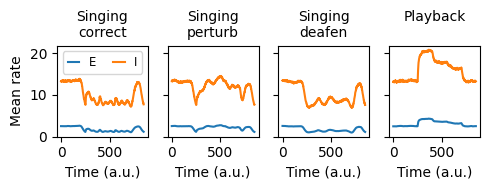

In [25]:
ti, tj = T_burn//2, T_burn+T_rend
fig, ax = plot_tests_mean(tests_all['rE'], tests_all['rI'], test_names, ti, tj)

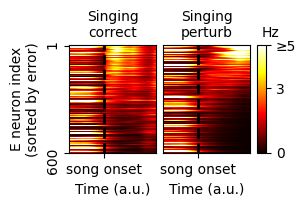

In [26]:
fig, ax = plot_raster_cmp_syl_dsyl(tests_all['rE'][0], tests_all['rE'][2], syl[0], 
                                   tests_all['bos'][2][0]-syl[0], 
                                   tsyl_start[0,0], tsyl_end[0,0], 
                                   figsize=(3, 2), plot_z=False)
# fig.savefig('svg/err_response_EI.svg')

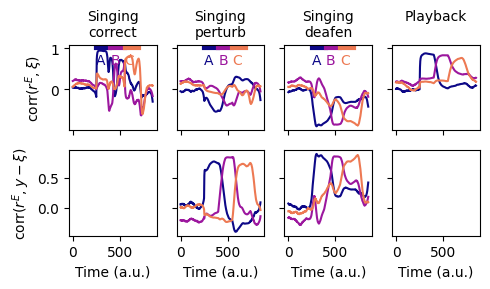

In [27]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-index-shuffled
idx = [(j, *ts[i]) for i, j in enumerate(tests_all['shuff_idx'][1])] # for index-shuffled
so = {0: aux, 1: aux, 2: aux}
fig, ax = plot_tests_corrs(rE_block_avgs, bos_block_avgs, syl_block_avgs, test_names,
                           ti, tj, tid_perturb_input=(1, 2), 
                           syl_order=so, y=1)

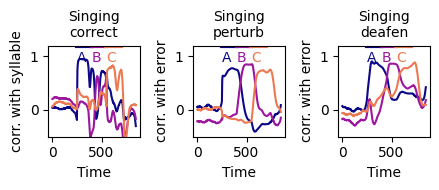

In [28]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-index-shuffled
idx = [(j, *ts[i]) for i, j in enumerate(tests_all['shuff_idx'][1])] # for index-shuffled
# Do not need to show playback
so = {0: aux, 1: aux, 2: aux}
fig, ax = plot_tests_corrs_simple(rE_block_avgs[:-1], bos_block_avgs[:-1], 
                                  syl_block_avgs, test_names[:-1],
                                  ti, tj, tid_perturb_input=(1, 2), 
                                  syl_order=so, y=1.2)
# fig.savefig('svg/corr_EI.svg')

450 150
84 66


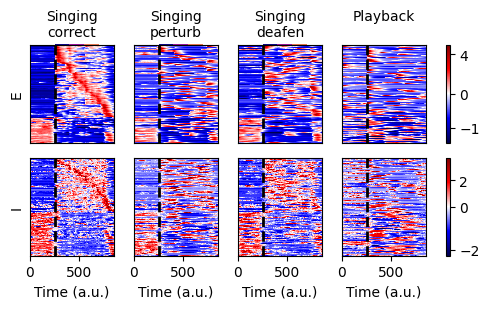

In [29]:
ti, tj = T_burn//2, T_burn + T_rend #int(tsyl_end[2,0])
fig, ax = plot_tests_raster(tests_all, test_names, 
                            ti, tj, T_burn, plot_inh=True, syl_order=so)
# fig.savefig('svg/raster_EI.svg')

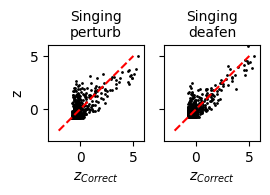

In [30]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_ctrl_vs_nonctrl(tests_all['rE'][:-1], test_names[:-1], ti, tj)
# fig, ax = plot_ctrl_vs_nonctrl(rE_block_avgs[:-1], test_names[:-1], ti, tj)
# fig.savefig('svg/joint_dist_c_vs_nc_EI.svg')

[(-1.0, 1.0)]

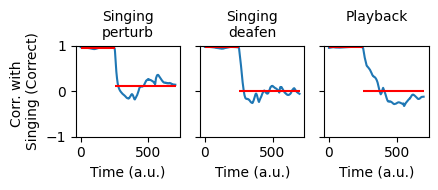

In [31]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_corr_ctrl_nonctrl(tests_all['rE'], test_names, ti, tj, T_burn)
# fig, ax = plot_corr_ctrl_nonctrl(rE_block_avgs, test_names, ti, tj, T_burn)
ax[0].set(ylim=[-1, 1])

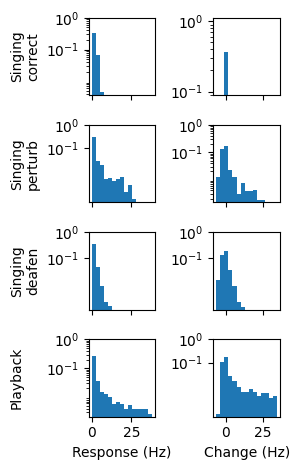

In [32]:
ti, tj = T_burn, int(tsyl_end[0,0])
fig, ax = plot_rate_and_change_dists(tests_all['rE'], test_names, tests_all['rE'][0], ti, tj)
# fig, ax = plot_rate_and_change_dists(rE_block_avgs, test_names, rE_block_avgs[0], ti, tj)

## Compare before and after using the same BOS's

In [33]:
net_ctrl = EINet(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, 
                 JEE=JEE, JEI=JEI, JIE=JIE, JII=JII, w_inh=w_inh, wI=wI, w0_std=1e-3)
net_ctrl.W = Ws[0]
exp_ctrl = Experiment(net_ctrl, rH, syl, noise=1, T_test=T_burn+T_rend, 
                      t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
tests_all_ctrl = exp_ctrl.sim_multi(test_codes, if_sing, 
                                    [(tests_all['bos'][1], 0)] * len(test_codes))

100%|█████████████████████████████████████| 1099/1099 [00:00<00:00, 3976.04it/s]


/tmp/ipykernel_152895/2540401701.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(ratios, labels=test_names, flierprops=dict(marker='.'))


181
121
99
221


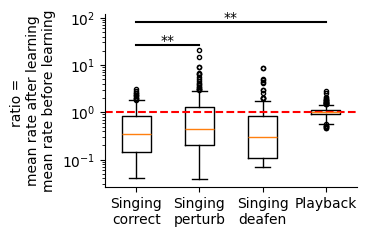

In [34]:
from scipy.stats import ttest_ind
i = 0
k = 0
ti, tj = int(tsyl_start[0,0]), int(tsyl_end[0,0])
ratios = []
fig, ax = plt.subplots(1, figsize=(3.5, 2.2))
for t_pre, t_post in zip(tests_all_ctrl['rE'], tests_all['rE']): 
    filter = (t_pre[ti:tj].mean(axis=0) >= 1) \
           & (t_post[ti:tj].mean(axis=0) >= 1)
    print(filter.sum())
    pre = t_pre[ti:tj,filter].mean(axis=0)
    post = t_post[ti:tj,filter].mean(axis=0)
    ratios.append(post/pre)

ax.boxplot(ratios, labels=test_names, flierprops=dict(marker='.'))
m = max(list(map(lambda x: x.max(), ratios)))
for i, ratio in enumerate(ratios[1:]):
    p = ttest_ind(ratios[0], ratio).pvalue
    if p < 0.01:
        _ = m * 10**(i*0.25+0.1)
        # _ = m + i * 0.8 + 0.5
        ax.plot([1, i+2], [_, _], c='k')
        if p < 0.001:
            ax.text((3+i)/2, _, '**', ha='center')
        else:
            ax.text((3+i)/2, _, '*', ha='center')

ax.axhline(1, color='r', ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set(yscale='log')
ax.set(ylabel='ratio = \nmean rate after learning\nmean rate before learning', yscale='log')
fig.tight_layout(pad=0.1)
# fig.savefig('svg/mean_ratio.svg')

In [35]:
# # Mutual information
# r, x = test_sp[0][T_burn:int(tsyl_end[0,0])].mean(axis=0), (syl - syl_sp)[0]
# joint_p = np.histogram2d(x, r, bins=50, density=True) # row is vertical dim.
# joint_p[0][:] += 1e-100
# p_r = np.histogram(r, bins=joint_p[2], density=True)
# p_r[0][:] += 1e-100
# p_x = np.histogram(x, bins=joint_p[1], density=True)
# p_x[0][:] += 1e-100
# dr, dx = joint_p[2][1] - joint_p[2][0], joint_p[1][1] - joint_p[1][0]
# h_x_given_r = -np.sum(joint_p[0] * (np.log(joint_p[0]) - np.log(p_r[0][None,:]))) * dr * dx
# h_x = -np.sum(p_x[0] * np.log(p_x[0])) * dx
# h_r = -np.sum(p_r[0] * np.log(p_r[0])) * dr
# h_x, h_r, h_x - h_x_given_r